In [1]:
# Developer Lab Notebook
# Experiment: Measure Inference Cost and GPU Usage

In [2]:
%matplotlib inline
import sys, os
sys.path.append(os.path.abspath(".."))

In [3]:
"""
4. The current result analysis does not fully address the risk of overfitting. Achieving 99.43% accuracy in CDS classification might be influenced 
by data imbalances or the characteristics of negative sampling (e.g., downsampling of non-CDS regions). It remains unclear whether the model relies 
on genuine sequence features or on confounding factors like ORF length. To improve confidence in the results, it would be helpful to include a 
confusion matrix, detailed performance on short ORFs (<300 bp), and further exploration of the model’s decision criteria. 
"""

'\n4. The current result analysis does not fully address the risk of overfitting. Achieving 99.43% accuracy in CDS classification might be influenced \nby data imbalances or the characteristics of negative sampling (e.g., downsampling of non-CDS regions). It remains unclear whether the model relies \non genuine sequence features or on confounding factors like ORF length. To improve confidence in the results, it would be helpful to include a \nconfusion matrix, detailed performance on short ORFs (<300 bp), and further exploration of the model’s decision criteria. \n'

Processing bacteria-1.fasta


CDS Prediction: 100%|██████████| 60/60 [07:02<00:00,  7.05s/it]
/tmp/ipykernel_924686/3746051638.py:84: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = df.groupby("LengthBin").apply(
/tmp/ipykernel_924686/3746051638.py:84: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  summary = df.groupby("LengthBin").apply(


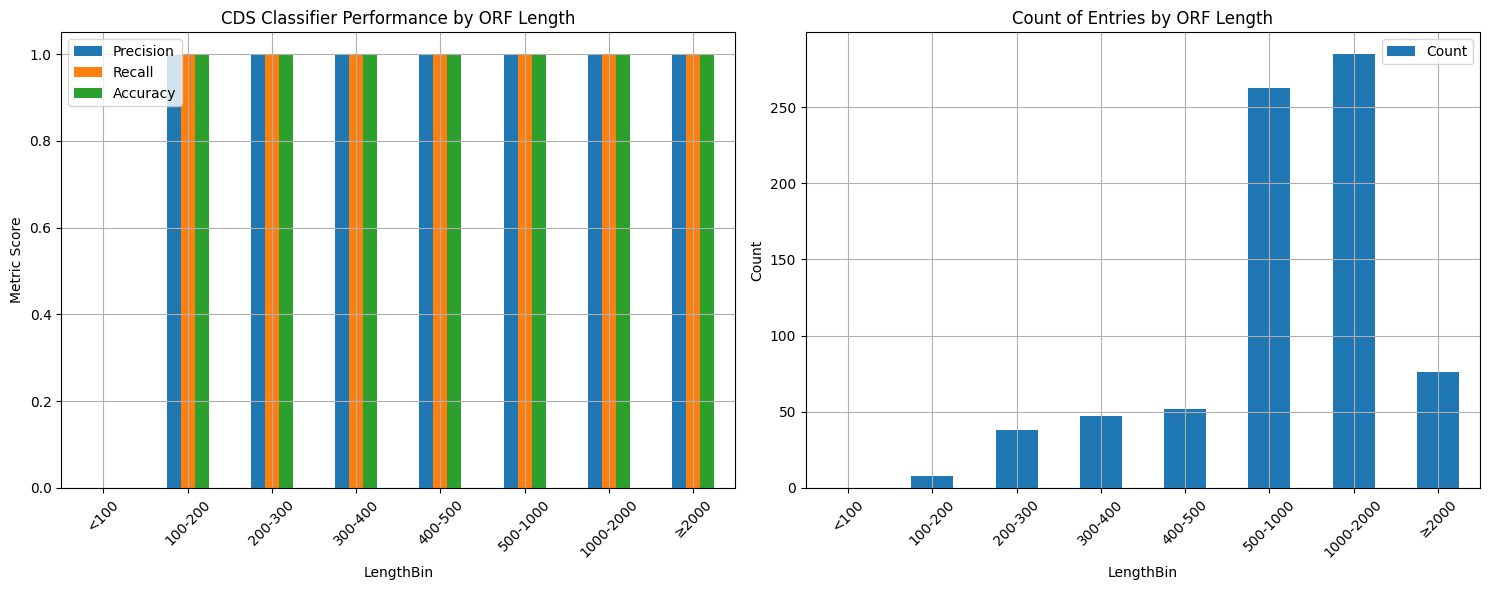

Processing bacteria-2.fasta


CDS Prediction: 100%|██████████| 24/24 [02:49<00:00,  7.06s/it]
/tmp/ipykernel_924686/3746051638.py:84: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = df.groupby("LengthBin").apply(
/tmp/ipykernel_924686/3746051638.py:84: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  summary = df.groupby("LengthBin").apply(


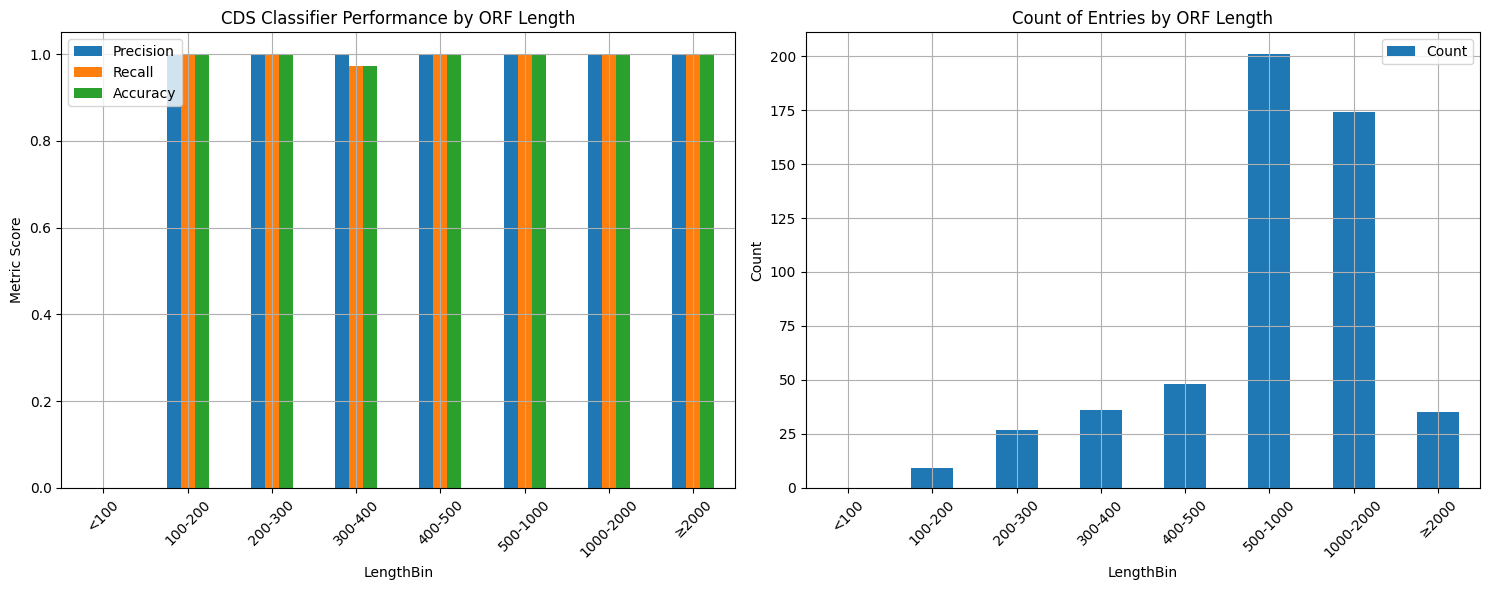

Processing bacteria-3.fasta


CDS Prediction: 100%|██████████| 65/65 [07:40<00:00,  7.09s/it]
/tmp/ipykernel_924686/3746051638.py:84: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = df.groupby("LengthBin").apply(
/tmp/ipykernel_924686/3746051638.py:84: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  summary = df.groupby("LengthBin").apply(


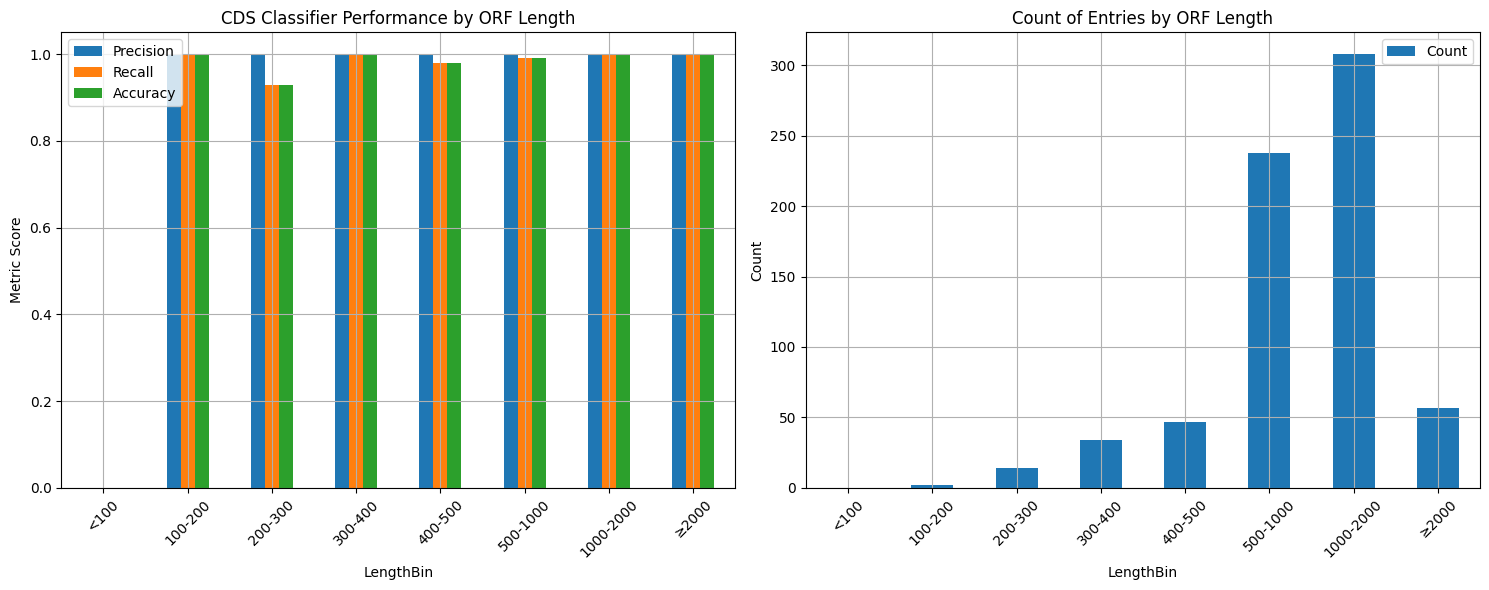

Processing bacteria-4.fasta


CDS Prediction: 100%|██████████| 37/37 [04:20<00:00,  7.05s/it]
/tmp/ipykernel_924686/3746051638.py:84: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = df.groupby("LengthBin").apply(
/tmp/ipykernel_924686/3746051638.py:84: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  summary = df.groupby("LengthBin").apply(


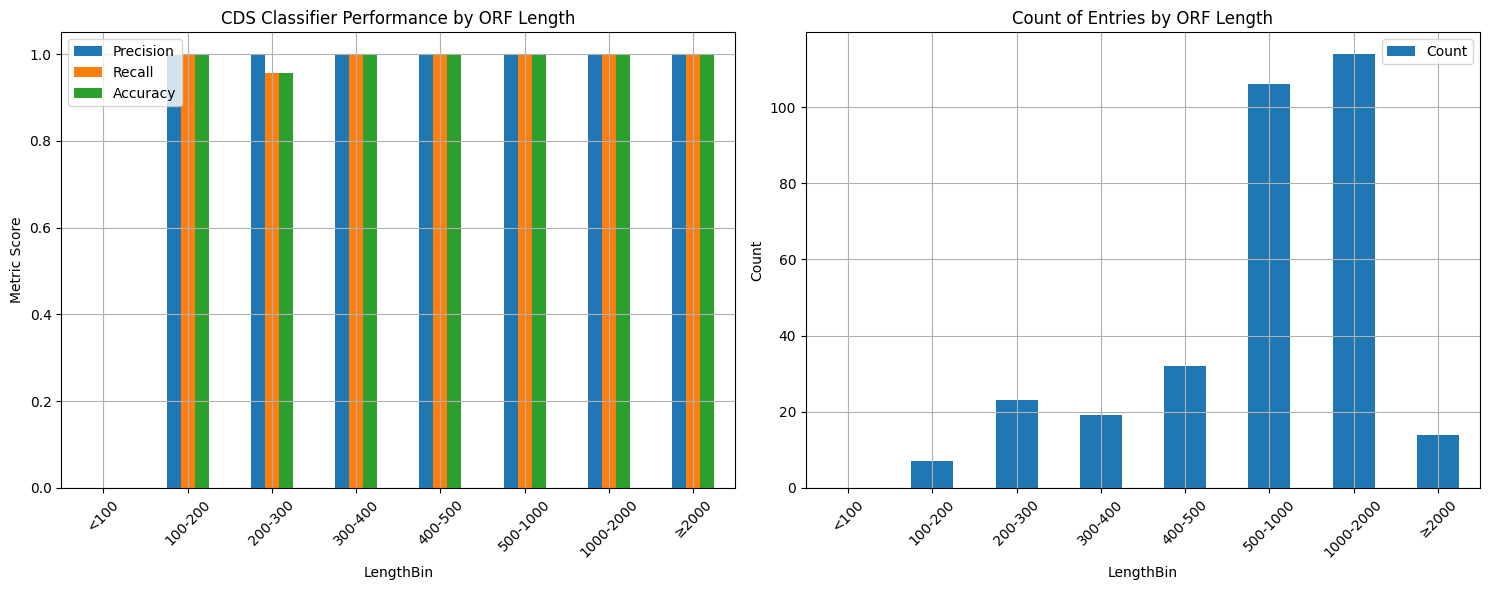

Processing bacteria-5.fasta


CDS Prediction: 100%|██████████| 62/62 [07:18<00:00,  7.08s/it]
/tmp/ipykernel_924686/3746051638.py:84: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = df.groupby("LengthBin").apply(
/tmp/ipykernel_924686/3746051638.py:84: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  summary = df.groupby("LengthBin").apply(


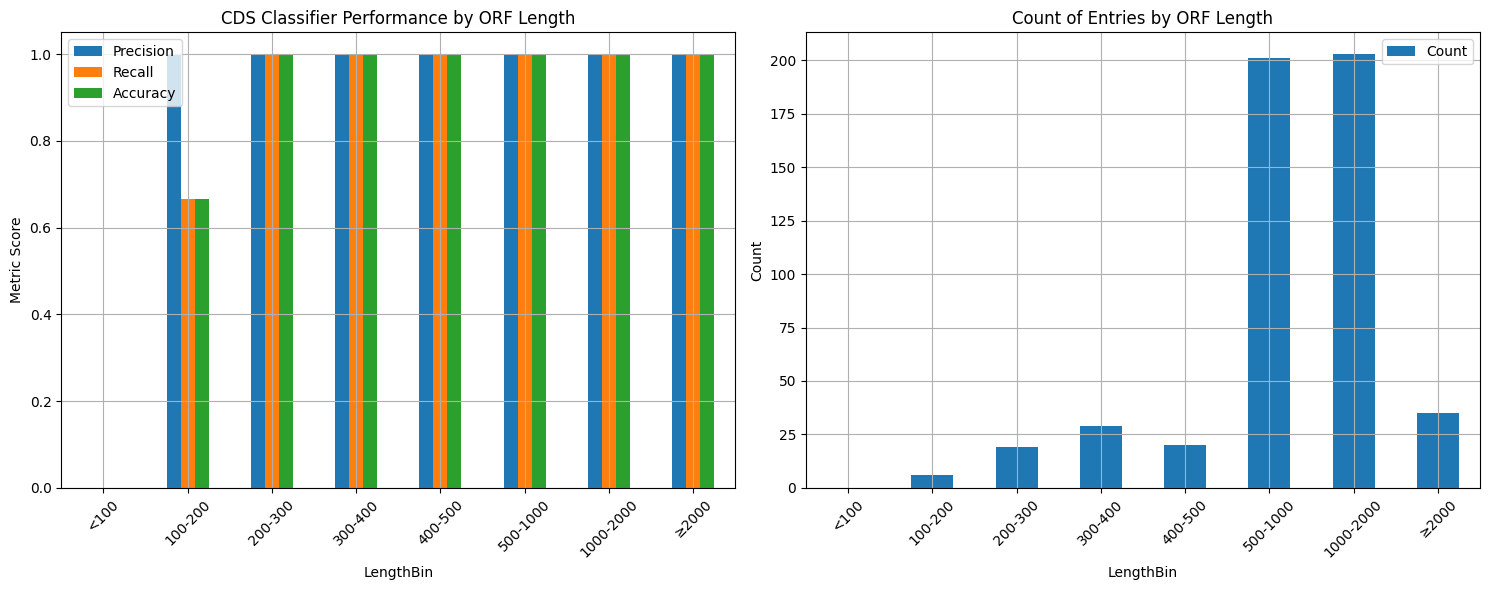

In [4]:
import pandas as pd
import numpy as np
import torch
from pathlib import Path
from Bio import SeqIO
import matplotlib.pyplot as plt
from api.core import AnnotatorPipeline
import orfipy_core as oc
from tqdm import tqdm

# Initialize
annotator = AnnotatorPipeline()
data_dir = Path('./data3-cds')
results = []

# Helper: parse .gff
def parse_gff(gff_file):
    cds_coords = set()
    with open(gff_file, 'r') as f:
        for line in f:
            if line.startswith("#"): continue
            parts = line.strip().split("\t")
            if len(parts) > 3 and parts[2] == "CDS":
                cds_coords.add((int(parts[3]), int(parts[4]), parts[6]))
    return cds_coords

# Experiment
gff_file = None
for fa_file in sorted(data_dir.glob("*.fasta")):
    gff_file = fa_file.with_suffix(".gff")
    if not gff_file.exists(): 
        continue

    print(f"Processing {fa_file.name}")
    cds_truth = parse_gff(gff_file)

    # --------
    record = None
    for record in SeqIO.parse(fa_file, "fasta"):
        record = record
        break
        
    seq = str(record.seq)
    seq_rc = str(record.seq.reverse_complement())
    orfs_pos, orfs_neg = annotator._parse_orfs(
        oc.start_search(seq, seq_rc, record.id, 10, 10000000, 'b',
                        ['TTG', 'CTG', 'ATG', 'GTG'],
                        ['TAA', 'TAG', 'TGA'], '1', True, False,
                        False, False, True,
                        [False, False, True, False, False])[2]
    )
    
    inputs = annotator._cds_input_parser(orfs_pos, "+") + annotator._cds_input_parser(orfs_neg, "-")
    sequences = [x["sequence"] for x in inputs]
    meta = [{"start": x["start"], "end": x["end"], "strand": x["strand"], "len": x["end"] - x["start"]} for x in inputs]
    preds = annotator._prediction(annotator.model_cds, annotator.tokenizer, sequences)

    # ---------
    results = []
    for p, m in zip(preds, meta):
        if m["strand"] == "-":
            label = 1 if m["start"]+1 in [x[0] for x in cds_truth if x[2] == "-"] else 0
        else:
            label = 1 if m["end"] in [x[1] for x in cds_truth  if x[2] == "+"] else 0
        
        results.append({
            "Genome": fa_file.name,
            "coords": (m["start"], m["end"], m["strand"]),
            "TrueLabel": label,
            "Length": m["len"],
            "PredLabel": p
        })

    # ---------
    results_ = [e for e in results if e['TrueLabel'] == 1]
    len(results_)

    # ---------
    # CSV
    df = pd.DataFrame(results_)
    bins = [0, 100, 200, 300, 400, 500, 1000, 2000, 10000]
    labels = ["<100", "100-200", "200-300", "300-400", "400-500", "500-1000", "1000-2000", "≥2000"]
    df["LengthBin"] = pd.cut(df["Length"], bins=bins, labels=labels, include_lowest=True)
    summary = df.groupby("LengthBin").apply(
        lambda g: pd.Series({
            "Count": len(g),
            "Precision": np.mean((g["PredLabel"] == 1) & (g["TrueLabel"] == 1)) / max(np.mean(g["PredLabel"] == 1), 1e-6),
            "Recall": np.mean((g["PredLabel"] == 1) & (g["TrueLabel"] == 1)) / max(np.mean(g["TrueLabel"] == 1), 1e-6),
            "Accuracy": np.mean(g["PredLabel"] == g["TrueLabel"])
        })
    ).reset_index()
    summary.to_csv(f"{fa_file}-cds_performance_by_orf_length.csv", index=False)

    # ---------
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    # Plot for Precision, Recall, and Accuracy
    summary.plot(x="LengthBin", y=["Precision", "Recall", "Accuracy"], kind="bar", ax=axes[0])
    axes[0].set_title("CDS Classifier Performance by ORF Length")
    axes[0].set_ylabel("Metric Score")
    axes[0].set_xticklabels(summary["LengthBin"], rotation=45)
    axes[0].grid(True)
    # Plot for Count
    summary.plot(x="LengthBin", y=["Count"], kind="bar", ax=axes[1])
    axes[1].set_title("Count of Entries by ORF Length")
    axes[1].set_ylabel("Count")
    axes[1].set_xticklabels(summary["LengthBin"], rotation=45)
    axes[1].grid(True)
    plt.tight_layout()
    plt.show()

In [5]:
# Aggregation

/tmp/ipykernel_924686/3535083947.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg_summary = merged_df.groupby("LengthBin").agg({


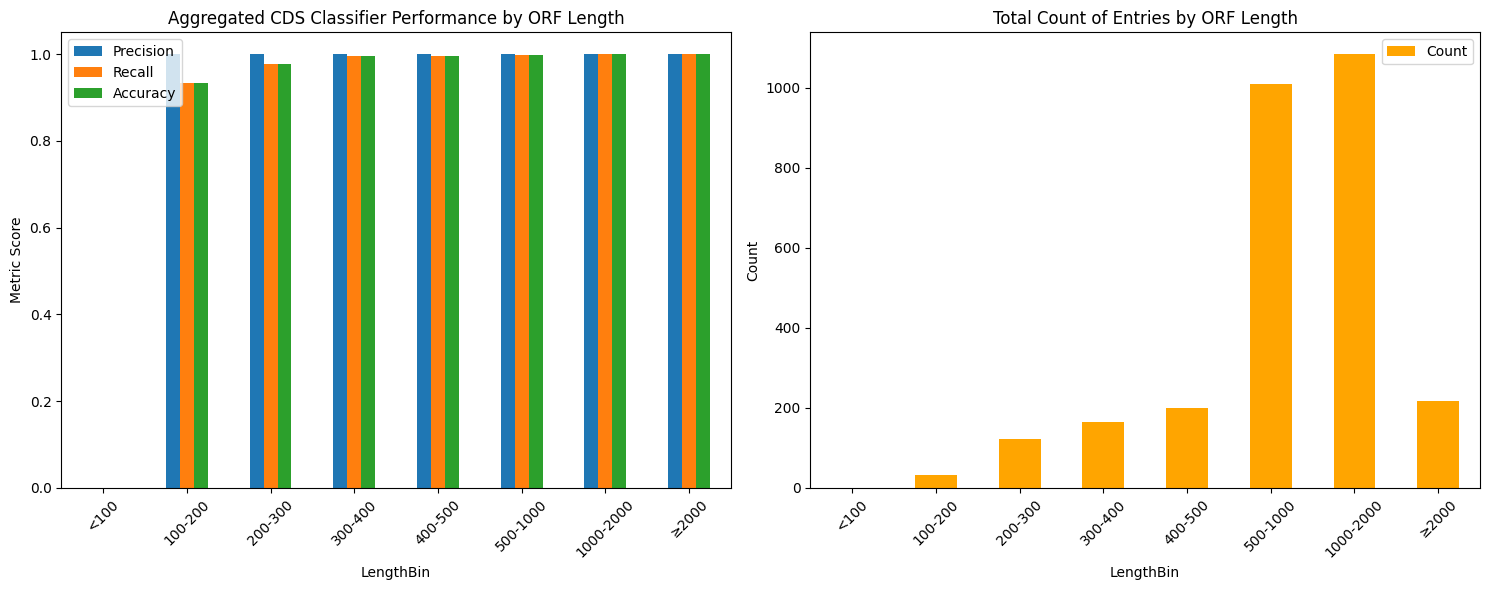

In [11]:
data_dir = Path('./data3-cds')
csv_files = list(data_dir.glob("*-cds_performance_by_orf_length.csv"))
all_dfs = []

for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    df["Genome"] = csv_file.name.split("-cds_performance_by_orf_length.csv")[0]
    all_dfs.append(df)

merged_df = pd.concat(all_dfs, ignore_index=True)
bin_order = ["<100", "100-200", "200-300", "300-400", "400-500", "500-1000", "1000-2000", "≥2000"]
merged_df["LengthBin"] = pd.Categorical(merged_df["LengthBin"], categories=bin_order, ordered=True)
agg_summary = merged_df.groupby("LengthBin").agg({
    "Precision": "mean",
    "Recall": "mean",
    "Accuracy": "mean",
    "Count": "sum"
}).reset_index()
agg_summary.to_csv(f"MERGED-cds_performance_by_orf_length.csv", index=False)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
agg_summary.plot(x="LengthBin", y=["Precision", "Recall", "Accuracy"], kind="bar", ax=axes[0])
axes[0].set_title("Aggregated CDS Classifier Performance by ORF Length")
axes[0].set_ylabel("Metric Score")
axes[0].set_xticklabels(agg_summary["LengthBin"], rotation=45)
axes[0].grid(False)
agg_summary.plot(x="LengthBin", y=["Count"], kind="bar", ax=axes[1], color="orange")
axes[1].set_title("Total Count of Entries by ORF Length")
axes[1].set_ylabel("Count")
axes[1].set_xticklabels(agg_summary["LengthBin"], rotation=45)
axes[1].grid(False)

plt.tight_layout()
plt.show()

In [ ]:
# END